In [26]:
# Active our virtual environment and confirm it worked
! source ./venv/bin/activate
! whereis python

zsh:source:1: no such file or directory: ./venv/bin/activate
python:


In [27]:
# define some helper functions to make our main event loop more readable
import math

def objName(event):
    return event["ObjectDetails"]["Name"]

def objPos(event):
    return event["ObjectDetails"]["Position"]

def stringToTuple(string):
    return tuple(float(x) for x in string[1:-1].split(','))

def moveDistance(start, end):
    return math.dist(stringToTuple(objPos(start)), stringToTuple(objPos(end)))


In [28]:
# define an ActivityPlan class that will allow us to create an activity plan in a stateful way
import json
from string import ascii_uppercase

class ActivityPlan:
    def __init__(self, path):
        self.activities = [] # an array that will store the activities in the plan
        self.counter = 0
        self.currentAdd1 = None # temporarily store a GameObject Added event as we deduce the occurence of slices
        self.currentAdd2 = None # temporarily store a GameObject Added event as we deduce the occurence of slices
        self.currentRemove = None # temporarily store a GameObject Removed event as we deduce the occurence of slices
        self.currentGrab = None # temporarily store a GameObject Picked Up event as we deduce the occurence of moves
        self.currentRelease = None # temporarily store a GameObject Let Go event as we deduce the occurence of moves
        self.loadEvents(path)
        print("# of events: ", len(self.events))
        self.parseEvents()

    def resetMove(self):
        self.currentGrab = None
        self.currentRelease = None
    
    def resetSlice(self):
        self.currentRemove = None
        self.currentAdd1 = None
        self.currentAdd2 = None

    def loadEvents(self, path):
        self.path = path
        with open(path, 'r') as f:
            self.events = json.load(f)

    def parseEvents(self):
        for event in self.events:
            if (event["EventType"] == "GameObject Added") : # Added (could be added due to a slice or the simulation starting)
                self.resetMove()
                if (objName(event).endswith("_0")):
                    self.currentAdd1 = event
                if (objName(event).endswith("_1")):
                    self.currentAdd2 = event
                self.attemptSliceActivity()

            if (event["EventType"] == "GameObject Removed") : # Removed (could be removed to to a slice or the simulation ending)
                self.resetMove()
                self.currentRemove = event
                self.attemptSliceActivity()

            if (event["EventType"] == "GameObject Picked Up") : # Picked Up (A game object was grabbed by the user)
                self.resetSlice()
                self.resetMove()
                self.currentGrab = event

            if (event["EventType"] == "GameObject Let Go") : # Let Go (A game object was released by the user)
                self.resetSlice()
                self.currentRelease = event
                self.attemptMoveActivity()

    def attemptMoveActivity(self):
            if (self.currentGrab and objName(self.currentGrab) == objName(self.currentRelease)):
                newActivity  = self.computeMove(self.currentGrab, self.currentRelease)
                self.addActivity(newActivity)

    def attemptSliceActivity(self):
        if (self.currentRemove and self.currentAdd1 and self.currentAdd2):
            newActivity = self.computeSlice(self.currentRemove, self.currentAdd1, self.currentAdd2)
            self.addActivity(newActivity)

    def addActivity(self, activity):
        activity["_id"] = ascii_uppercase[self.counter]
        self.activities.append(activity)
        self.counter += 1

    def computeDependencies(self, new):
        dependencies = []
        for previous in self.activities:
            if (new["object"] in previous["dependentObjects"]):
                dependencies.append(previous["_id"])
        if (len(dependencies) == 0):
            dependencies = [None]
        return dependencies


    def computeMove(self, start, end):
        # print(objName(start), "moved from:", objPos(start), "to:", objPos(end))
        activity = {
            "type": "move",
            "object": objName(start),
            "dependentObjects": [objName(start)],
            "startEvent": start,
            "endEvent": end,
            "startPosition": stringToTuple(objPos(start)),
            "endPosition": stringToTuple(objPos(end)),
            "moveDistance": moveDistance(start, end),
        }
        activity["description"] = "Move \"" + objName(start) + "\""
        activity["duration"] = round(activity["moveDistance"], 1)
        activity["dependencies"] = self.computeDependencies(activity)
        return activity

    def computeSlice(self, remove, create1, create2):
        activity = {
            "type": "slice",
            "object": objName(remove),
            "dependentObjects": [objName(remove), objName(create1), objName(create2)],
            "removeEvent": remove,
            "createEvent1": create1,
            "createEvent2": create2
        }
        activity["description"] = "Slice \"" + objName(remove) + "\""
        activity["duration"] = 2
        activity["dependencies"] = self.computeDependencies(activity)
        return activity

# of events:  36
Activity	 Duration	 Dependencies		 Description	
A 		 3.6 		 [None] 			 Move "Mechanical_Equipment__HVAC_Other_Chromalox_MVSGI-High-Capacity-Steam-Generator__Not_a_Type_-_Load_Type_Catalog!__326873:36"
B 		 4.0 		 [None] 			 Move "Mechanical_Equipment__HVAC_Other_Chromalox_MVSGI-High-Capacity-Steam-Generator__Not_a_Type_-_Load_Type_Catalog!__326873:20"
C 		 2 		 ['B'] 			 Slice "Mechanical_Equipment__HVAC_Other_Chromalox_MVSGI-High-Capacity-Steam-Generator__Not_a_Type_-_Load_Type_Catalog!__326873:20"
D 		 1.4 		 ['C'] 			 Move "Mechanical_Equipment__HVAC_Other_Chromalox_MVSGI-High-Capacity-Steam-Generator__Not_a_Type_-_Load_Type_Catalog!__326873:20_1"
E 		 1.9 		 ['C'] 			 Move "Mechanical_Equipment__HVAC_Other_Chromalox_MVSGI-High-Capacity-Steam-Generator__Not_a_Type_-_Load_Type_Catalog!__326873:20_0"
F 		 0.3 		 [None] 			 Move "Mechanical_Equipment__HVAC_Other_Chromalox_MVSGI-High-Capacity-Steam-Generator__Not_a_Type_-_Load_Type_Catalog!__326873:19"
G 		 4.5 		 [None

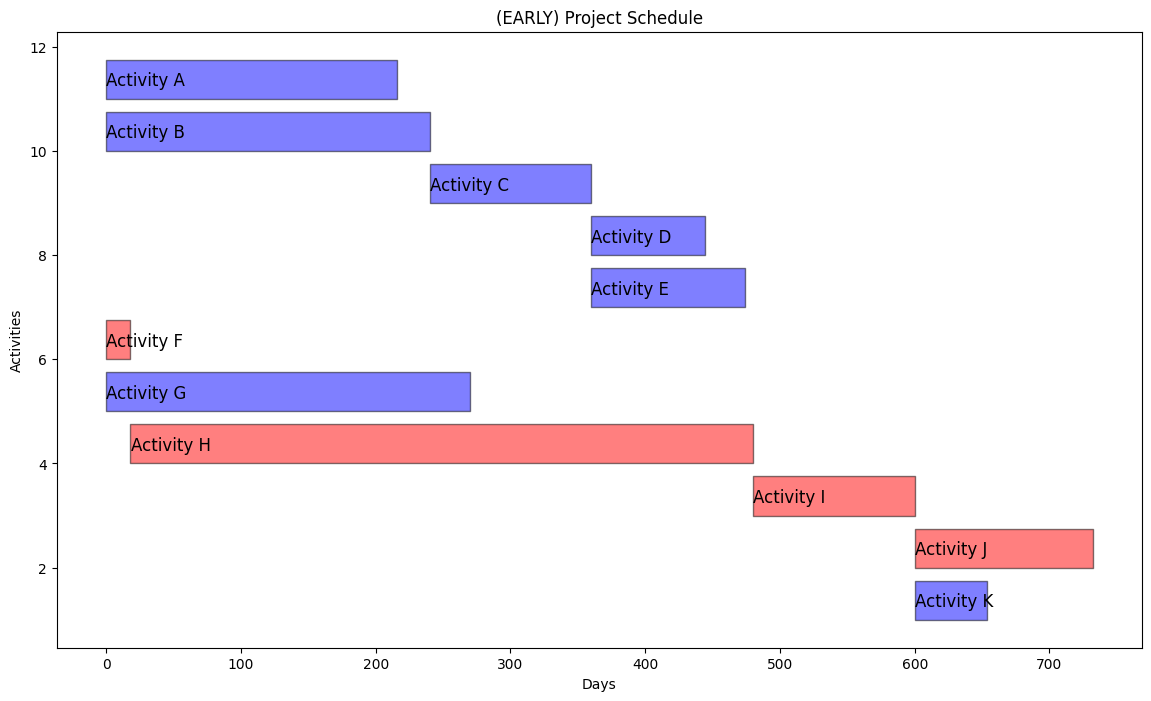

In [29]:
import time
start = time.time()

# create and analyze the activity plan using our ActivityPlan class
myPlan = ActivityPlan('./LogFile 1.json')

# cheche_pm allows us to create a critical path schedule diagram from our ActivityPlan class
from cheche_pm import Project
p = Project()

print ("Activity\t", "Duration\t", "Dependencies\t\t", "Description\t")
for activity in myPlan.activities:
    p.add_activity(activity_name=activity["_id"], activity_duration = 60 * activity["duration"], activity_precedence=[activity["dependencies"][len(activity["dependencies"])-1]], a_desc=activity["description"], activity_resources=[0])
    print(activity["_id"], "\t\t", activity["duration"], "\t\t", activity["dependencies"], "\t\t\t", activity["description"])

try:
    p.CPM()
    print("--- %s seconds ---" % (time.time() - start))
    print(p.get_critical_path())
    p.plot_gantt_cpm(save=True)
except:
    pass